# Exploratory Data Analysis


## Data Collection


In [ ]:
# %pip install pingouin

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import pingouin as pg
from scipy.stats import probplot, shapiro, pearsonr, friedmanchisquare
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.formula.api import ols
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Read data
data_2015 = pd.read_csv("data/2015.csv")
data_2016 = pd.read_csv("data/2016.csv")
data_2017 = pd.read_csv("data/2017.csv")
data_2018 = pd.read_csv("data/2018.csv")
data_2019 = pd.read_csv("data/2019.csv")

Here, we imported the necessary libraries and loaded the data.


## Data Preprocessing


In [ ]:
# Add year column to each dataset
data_2015["Year"] = 2015
data_2016["Year"] = 2016
data_2017["Year"] = 2017
data_2018["Year"] = 2018
data_2019["Year"] = 2019

# Rename columns for consistency
data_2017.rename(
    columns={
        "Happiness.Rank": "Happiness Rank",
        "Happiness.Score": "Happiness Score",
        "Economy..GDP.per.Capita.": "Economy (GDP per Capita)",
        "Health..Life.Expectancy.": "Health (Life Expectancy)",
        "Trust..Government.Corruption.": "Trust (Government Corruption)",
        "Dystopia.Residual": "Dystopia Residual",
    },
    inplace=True,
)

data_2018.rename(
    columns={
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy (GDP per Capita)",
        "Social support": "Family",
        "Healthy life expectancy": "Health (Life Expectancy)",
        "Freedom to make life choices": "Freedom",
        "Perceptions of corruption": "Trust (Government Corruption)",
    },
    inplace=True,
)

data_2019.rename(
    columns={
        "Overall rank": "Happiness Rank",
        "Country or region": "Country",
        "Score": "Happiness Score",
        "GDP per capita": "Economy (GDP per Capita)",
        "Social support": "Family",
        "Healthy life expectancy": "Health (Life Expectancy)",
        "Freedom to make life choices": "Freedom",
        "Perceptions of corruption": "Trust (Government Corruption)",
    },
    inplace=True,
)

# Remove columns that are not common to all datasets
common_columns = list(
    set(data_2015.columns)
    & set(data_2016.columns)
    & set(data_2017.columns)
    & set(data_2018.columns)
    & set(data_2019.columns)
)
data_2015 = data_2015[common_columns]
data_2016 = data_2016[common_columns]
data_2017 = data_2017[common_columns]
data_2018 = data_2018[common_columns]
data_2019 = data_2019[common_columns]

# Remove countries that are not common to all datasets
common_countries = list(
    set(data_2015["Country"]).intersection(
        set(data_2016["Country"]),
        set(data_2017["Country"]),
        set(data_2018["Country"]),
        set(data_2019["Country"]),
    )
)

# Update the datasets based on the common_countries list
data_2015 = data_2015[data_2015["Country"].isin(common_countries)]
data_2016 = data_2016[data_2016["Country"].isin(common_countries)]
data_2017 = data_2017[data_2017["Country"].isin(common_countries)]
data_2018 = data_2018[data_2018["Country"].isin(common_countries)]
data_2019 = data_2019[data_2019["Country"].isin(common_countries)]

# Merge all datasets into one
data = pd.concat(
    [data_2015, data_2016, data_2017, data_2018, data_2019],
    ignore_index=True,
    sort=False,
)

# Clean missing data (if any)
data = data.dropna()

# if any country appears less than the total amount of years, remove it
data = data.groupby("Country").filter(lambda x: len(x) == len(data["Year"].unique()))
all_countries = data["Country"]

data

,Health (Life Expectancy),Happiness Score,Happiness Rank,Family,Trust (Government Corruption),Economy (GDP per Capita),Generosity,Freedom,Country,Year
0,0.94143,7.587,1,1.34951,0.41978,1.39651,0.29678,0.66557,Switzerland,2015
1,0.94784,7.561,2,1.40223,0.14145,1.30232,0.43630,0.62877,Iceland,2015
2,0.87464,7.527,3,1.36058,0.48357,1.32548,0.34139,0.64938,Denmark,2015
3,0.88521,7.522,4,1.33095,0.36503,1.45900,0.34699,0.66973,Norway,2015
4,0.90563,7.427,5,1.32261,0.32957,1.32629,0.45811,0.63297,Canada,2015
...,...,...,...,...,...,...,...,...,...,...
700,0.49500,3.410,150,0.56000,0.08900,0.19100,0.21800,0.44300,Malawi,2019
701,0.46300,3.380,151,1.16300,0.07700,0.28700,0.10800,0.14300,Yemen,2019
702,0.61400,3.334,152,0.71100,0.41100,0.35900,0.21700,0.55500,Rwanda,2019
703,0.49900,3.231,153,0.88500,0.14700,0.47600,0.27600,0.41700,Tanzania,2019


Here, we merged the data and cleaned it. In order to merge the data, we removed columns and countries that were not present in all datasets, and rows that had missing values.


## Contextual Descriptive Analysis


### Cardinality and Counts


Total amount of countries:  140
Total amount of years:  5
Number of each country:
Switzerland    5
Iran           5
Hungary        5
Honduras       5
Tajikistan     5
              ..
Japan          5
Slovakia       5
Uzbekistan     5
Guatemala      5
Togo           5
Name: Country, Length: 140, dtype: int64

Improved countries: 
 Armenia, Bahrain, Benin, Bosnia and Herzegovina, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Chad, Congo (Brazzaville), Cyprus, Czech Republic, Dominican Republic, El Salvador, Estonia, Gabon, Georgia, Germany, Ghana, Greece, Guatemala, Guinea, Honduras, Hungary, Italy, Ivory Coast, Jamaica, Kosovo, Latvia, Lebanon, Lithuania, Mali, Malta, Mauritius, Mongolia, Montenegro, Nepal, Nicaragua, Niger, Pakistan, Philippines, Poland, Portugal, Romania, Saudi Arabia, Senegal, Serbia, Slovakia, Slovenia, South Africa, Spain, Syria, Tajikistan, Togo, United Kingdom

Stable countries: 
 Afghanistan, Australia, Austria, Belgium, Canada, Chile, Costa Rica, Denmar

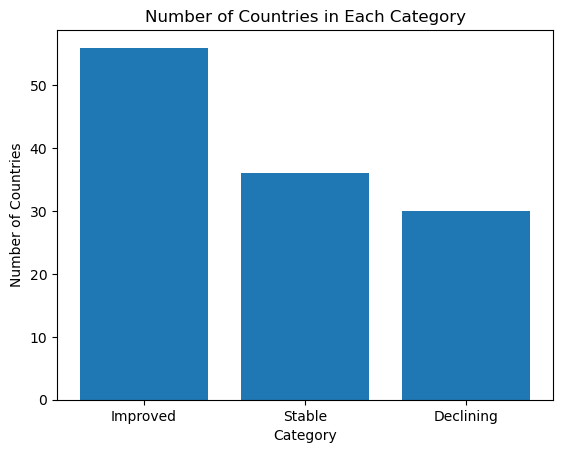

In [ ]:
print("Total amount of countries: ", len(data["Country"].unique()))
print("Total amount of years: ", len(data["Year"].unique()))

# Check the number of each country
print("Number of each country:")
print(data["Country"].value_counts())

# Calculate ranking change for each country
country_ranking_changes = data.pivot_table(
    index="Country", columns="Year", values="Happiness Rank"
)
country_ranking_changes["Ranking Change"] = (
    country_ranking_changes[2019] - country_ranking_changes[2015]
)
country_ranking_changes = country_ranking_changes.dropna()

countries = {
    "Improved": country_ranking_changes[
        (country_ranking_changes["Ranking Change"] * -1) > 5
    ].index.tolist(),
    "Stable": country_ranking_changes[
        abs(country_ranking_changes["Ranking Change"]) <= 5
    ].index.tolist(),
    "Declining": country_ranking_changes[
        (country_ranking_changes["Ranking Change"] * -1) < -10
    ].index.tolist(),
}

# Print countries in each category
for key, value in countries.items():
    print()
    print(key + " countries: \n", ", ".join(value))

# Create a bar plot of the number of countries in each category
plt.bar(countries.keys(), [len(value) for value in countries.values()])
plt.xlabel("Category")
plt.ylabel("Number of Countries")
plt.title("Number of Countries in Each Category")
plt.show()

First thing's first: each country appears as many times as there are years in the dataset, no more, no fewer.

The ranking of a country can improve, remain stable, or decline over the years. The data shows more countries have experienced an improvement in their happiness rankings than those that have remained stable, and more countries have remained stable than those that have declined (though to a lesser extent).

The improved countries have experienced significant improvements in their happiness rankings. This list includes countries at different stages of development and from different regions. These countries may have experienced recent improvements in various aspects, such as economic growth, social development, or political stability, like China and India.

The stable countries have maintained a stable level of happiness among their citizens. The list includes countries with strong social support systems, high living standards, and low levels of corruption, like the Nordic countries. However, there are countries like Afghanistan and Myanmar, which face significant challenges in terms of stability, security, and human rights.

The declining countries have seen a significant drop in thier happiness ranking (>10). This list also includes countries at different stages of development and from different regions, from developed countries like Japan to developing nations like Zimbabwe.


### Distribution


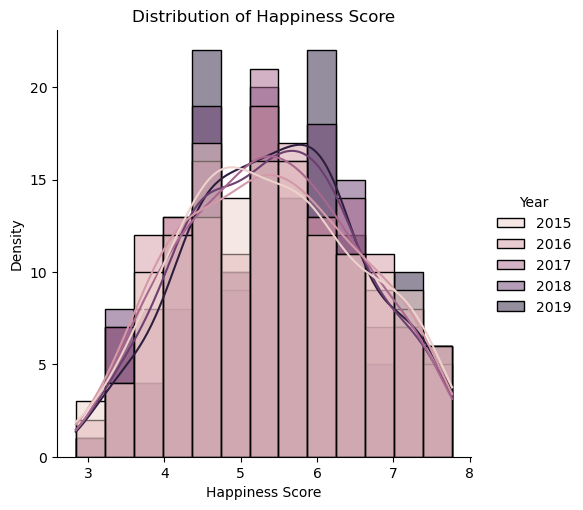

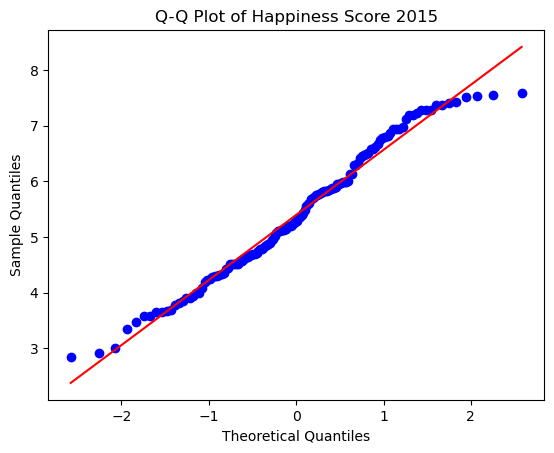

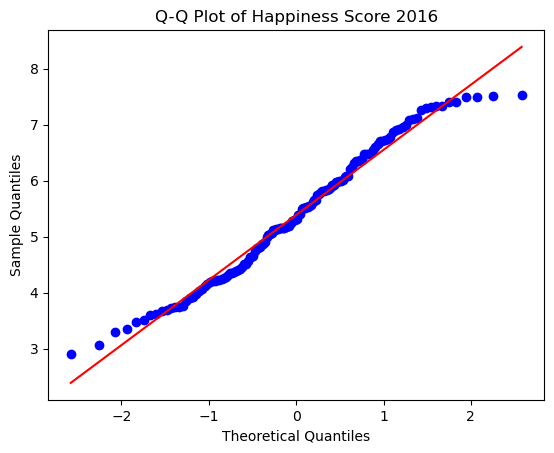

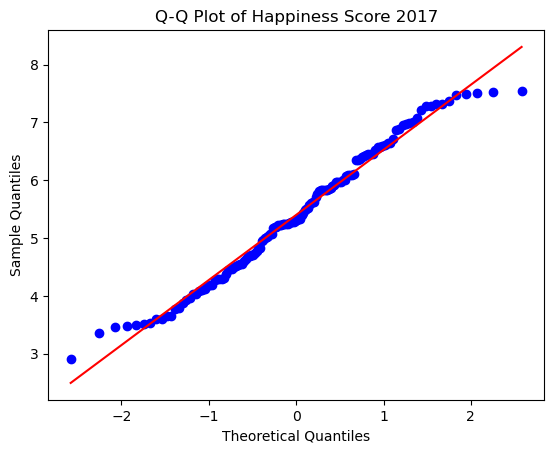

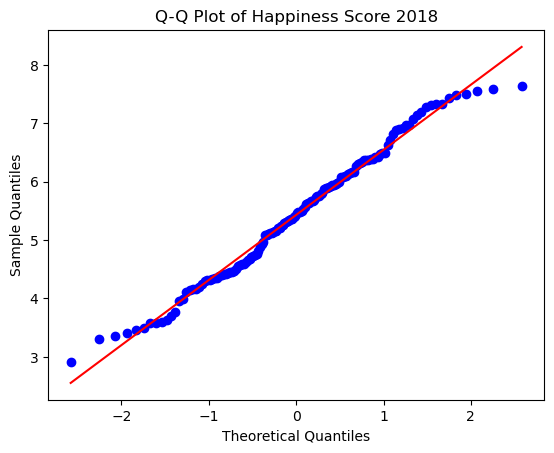

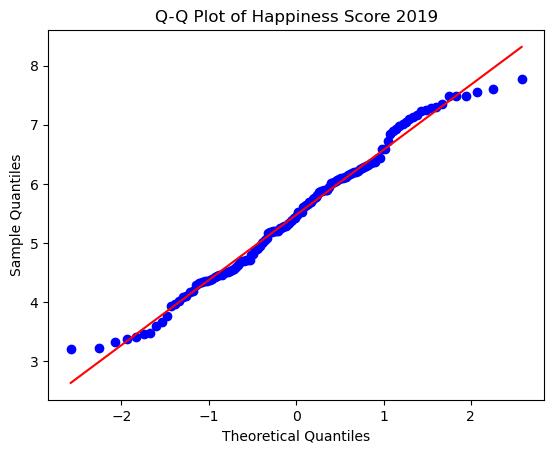

Shapiro-Wilk test for 2015:
Test statistic: 0.9783193469047546
p-value: 0.025181667879223824

Shapiro-Wilk test for 2016:
Test statistic: 0.9766185283660889
p-value: 0.01669076271355152

Shapiro-Wilk test for 2017:
Test statistic: 0.979928731918335
p-value: 0.037322599440813065

Shapiro-Wilk test for 2018:
Test statistic: 0.9839982986450195
p-value: 0.10190026462078094

Shapiro-Wilk test for 2019:
Test statistic: 0.9841199517250061
p-value: 0.10500217229127884



In [ ]:
# Create a density plot of the "Happiness Score" column
sns.displot(data=data, x="Happiness Score", hue="Year", kde=True)

# Add labels and title
plt.xlabel("Happiness Score")
plt.ylabel("Density")
plt.title("Distribution of Happiness Score")
plt.show()

# check if Happiness Score is normally distributed using QQ plots
for i in range(2015, 2020):
    probplot(data[data["Year"] == i]["Happiness Score"], dist="norm", plot=plt)
    plt.title("Q-Q Plot of Happiness Score " + str(i))
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

# check if Happiness Score is normally distributed using Shapiro-Wilk test
for i in range(2015, 2020):
    result = shapiro(data[data["Year"] == i]["Happiness Score"])
    print("Shapiro-Wilk test for " + str(i) + ":")
    print("Test statistic: " + str(result[0]))
    print("p-value: " + str(result[1]))
    print("")

The histogram has a bell-shaped curve and the Q-Q plots show the points lying approximately on a straight line, so the Happiness Scores seem to be normally distributed.

The Shapiro-Wilk test is a statistical test to assess the null hypothesis that a given sample comes from a normally distributed population. If we choose a p-value of 0.01, none of the years' Happiness Scores are rejected as coming from a normally distributed population. The test statistics are also very close to 1 -- further evidence that the Happiness Scores are normally distributed.


### Quantile Statistics


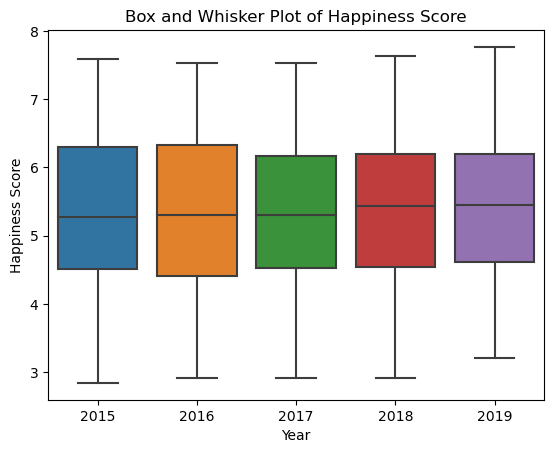

Statistics for 2015:
Min: 2.84
Max: 7.59
Range: 4.75
Q1: 4.52
Q3: 6.30
IQR: 1.78

Statistics for 2016:
Min: 2.90
Max: 7.53
Range: 4.62
Q1: 4.40
Q3: 6.33
IQR: 1.93

Statistics for 2017:
Min: 2.90
Max: 7.54
Range: 4.63
Q1: 4.53
Q3: 6.16
IQR: 1.64

Statistics for 2018:
Min: 2.90
Max: 7.63
Range: 4.73
Q1: 4.54
Q3: 6.19
IQR: 1.65

Statistics for 2019:
Min: 3.20
Max: 7.77
Range: 4.57
Q1: 4.62
Q3: 6.20
IQR: 1.58



In [ ]:
# box and whisker plots for Happiness Score
sns.boxplot(data=data, x="Year", y="Happiness Score")
plt.xlabel("Year")
plt.ylabel("Happiness Score")
plt.title("Box and Whisker Plot of Happiness Score")
plt.show()

# print the quantiles for each year along with min, max, range, and IQR
for i in range(2015, 2020):
    year_data = data[data["Year"] == i]["Happiness Score"]
    min_value = year_data.min()
    max_value = year_data.max()
    range_value = max_value - min_value
    Q1 = year_data.quantile(0.25)
    Q3 = year_data.quantile(0.75)
    IQR = Q3 - Q1
    print(f"Statistics for {i}:")
    print(f"Min: {min_value:.2f}")
    print(f"Max: {max_value:.2f}")
    print(f"Range: {range_value:.2f}")
    print(f"Q1: {Q1:.2f}")
    print(f"Q3: {Q3:.2f}")
    print(f"IQR: {IQR:.2f}\n")

There seems to be a slight upward trend in the Happiness Scores from 2015 to 2019, as indicated by the increase in the quartiles. While there are fluctuations from year to year, they are not dramatic, which suggests the scores remained relatively stable over this period. The IQR shows a slight decreasing trend, suggesting that the variability of the scores around the median has slightly decreased. This could imply that over time, the scores of countries are becoming more similar.


### Descriptive Statistics


#### Central Tendency


Mean Happiness Score by Year
Year
2015    5.396043
2016    5.389493
2017    5.399436
2018    5.430629
2019    5.475814
Name: Happiness Score, dtype: float64

Median Happiness Score by Year
Year
2015    5.2770
2016    5.3085
2017    5.3020
2018    5.4410
2019    5.4495
Name: Happiness Score, dtype: float64

Mode Happiness Score by Year
Year
2015    5.192
2016    3.739
2017    5.074
2018    5.358
2019    5.208
Name: Happiness Score, dtype: float64



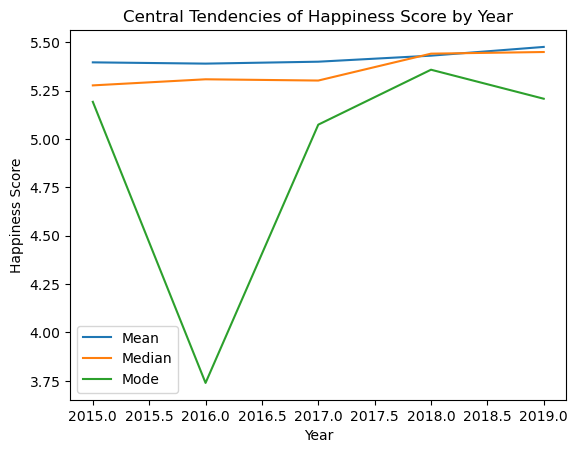

In [ ]:
def first_mode(series):
    return series.mode().iloc[0]


mean_happiness_by_year = data.groupby("Year")["Happiness Score"].mean()
median_happiness_by_year = data.groupby("Year")["Happiness Score"].median()
mode_happiness_by_year = data.groupby("Year")["Happiness Score"].agg(first_mode)

tendencies = {
    "Mean": mean_happiness_by_year,
    "Median": median_happiness_by_year,
    "Mode": mode_happiness_by_year,
}

for key, value in tendencies.items():
    plt.plot(value, label=key)
    print(key + " Happiness Score by Year")
    print(value)
    print()

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Happiness Score")
plt.title("Central Tendencies of Happiness Score by Year")
plt.legend()
plt.show()

Both the mean and median Happiness Scores support the claim that happiness levels remained relatively
stable across the years, even suggesting they increased slightly. The mode, however, might not be the best measure to represent the central tendency of the data, as it varies more and may not accurately reflect the overall trend in Happiness Scores.


#### Variability


Standard Deviation Happiness Score by Year
Year
2015    1.167134
2016    1.159604
2017    1.121747
2018    1.108296
2019    1.094109
Name: Happiness Score, dtype: float64

Variance Happiness Score by Year
Year
2015    1.362201
2016    1.344682
2017    1.258317
2018    1.228320
2019    1.197074
Name: Happiness Score, dtype: float64

Range Happiness Score by Year
Year
2015    4.748
2016    4.621
2017    4.632
2018    4.727
2019    4.566
Name: Happiness Score, dtype: float64



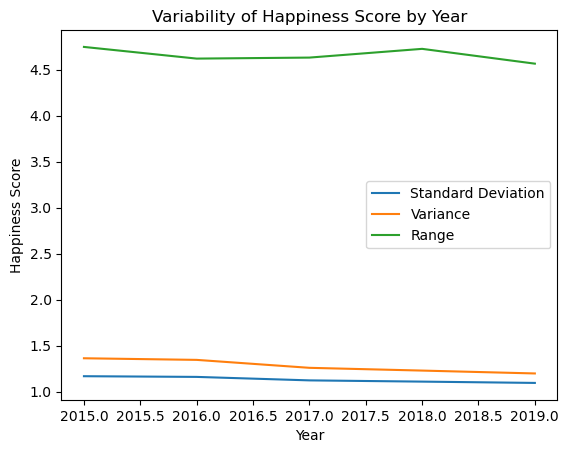

In [ ]:
std_happiness_by_year = data.groupby("Year")["Happiness Score"].std()
var_happiness_by_year = data.groupby("Year")["Happiness Score"].var()
range_happiness_by_year = (
    data.groupby("Year")["Happiness Score"].max()
    - data.groupby("Year")["Happiness Score"].min()
)

variabilitys = {
    "Standard Deviation": std_happiness_by_year,
    "Variance": var_happiness_by_year,
    "Range": range_happiness_by_year,
}

for key, value in variabilitys.items():
    plt.plot(value, label=key)
    print(key + " Happiness Score by Year")
    print(value)
    print()

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Happiness Score")
plt.title("Variability of Happiness Score by Year")
plt.legend()
plt.show()

The variability of Happiness Scores has also remained relatively stable across the years, even decreasing slightly, which also supports the quantile analysis.


## Correlation Analysis


### Qualitative Analysis


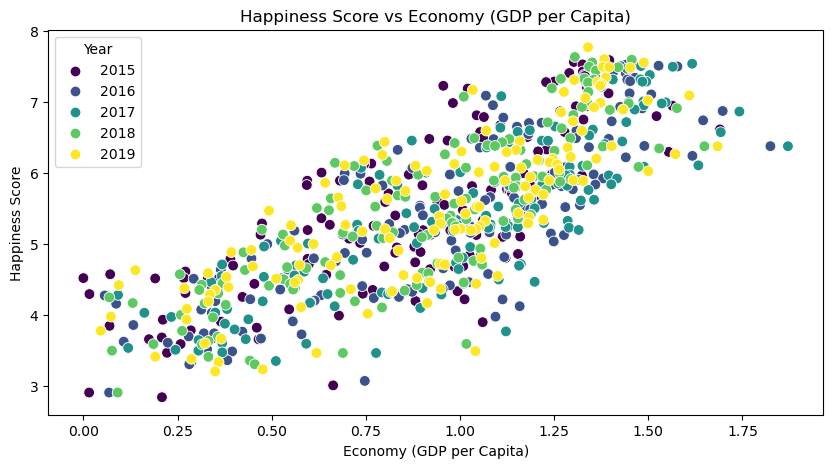

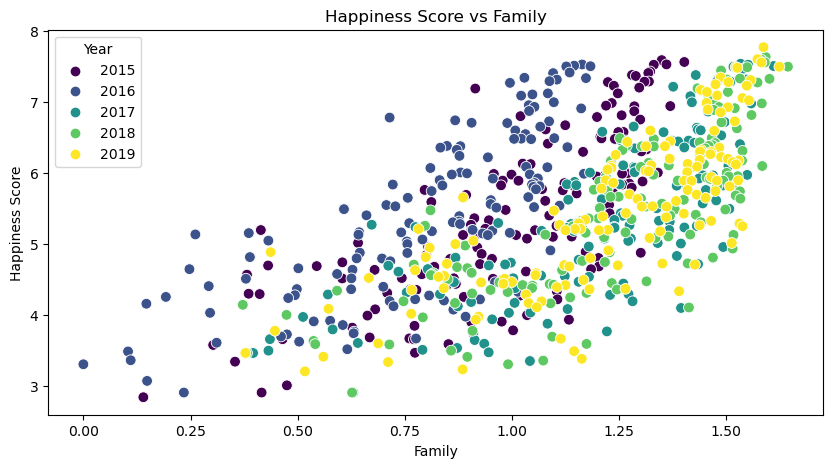

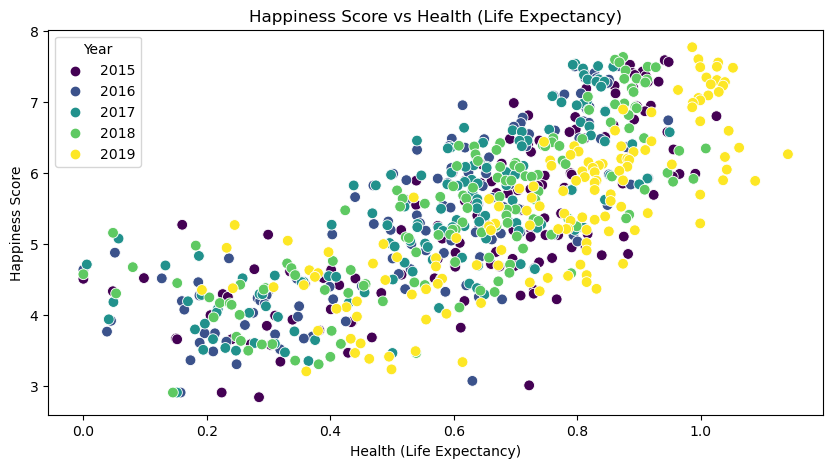

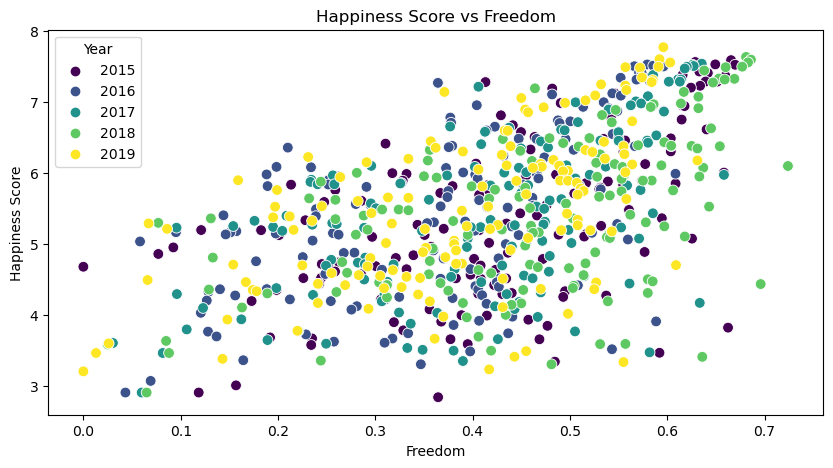

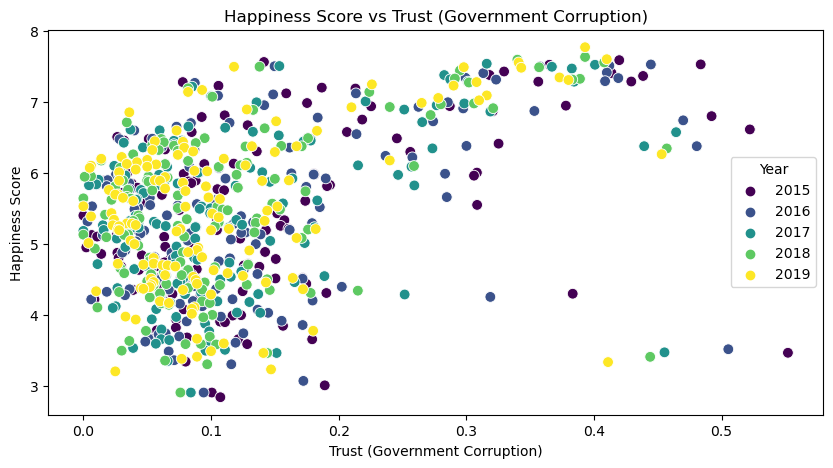

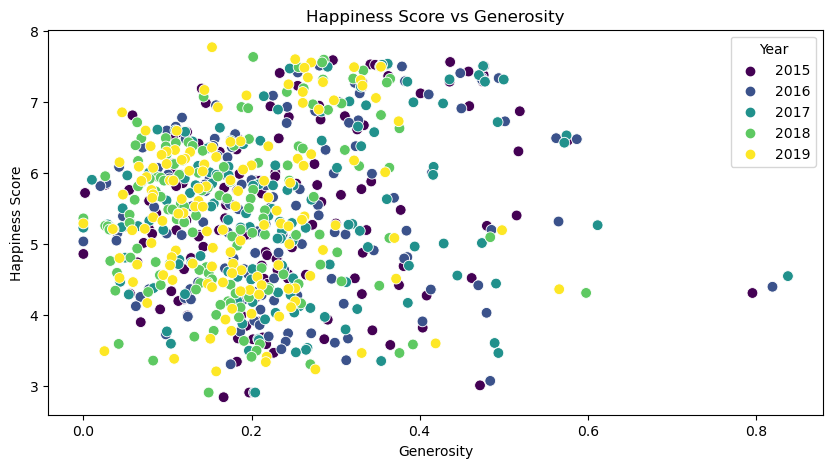

In [ ]:
features = [
    "Economy (GDP per Capita)",
    "Family",
    "Health (Life Expectancy)",
    "Freedom",
    "Trust (Government Corruption)",
    "Generosity",
]

for feature in features:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        data=data, x=feature, y="Happiness Score", hue="Year", palette="viridis", s=60
    )
    plt.title("Happiness Score vs " + feature)
    plt.show()

The scatterplots show that Happiness Score and Economy (GDP per Capita) and Family have a strong positive correlation. Happiness Score and Health (Life Expectancy) and Freedom have a moderate positive correlation. Happiness Score and Trust (Government Corruption) and Generosity have a weak positive correlation.


### Quantitative Analysis


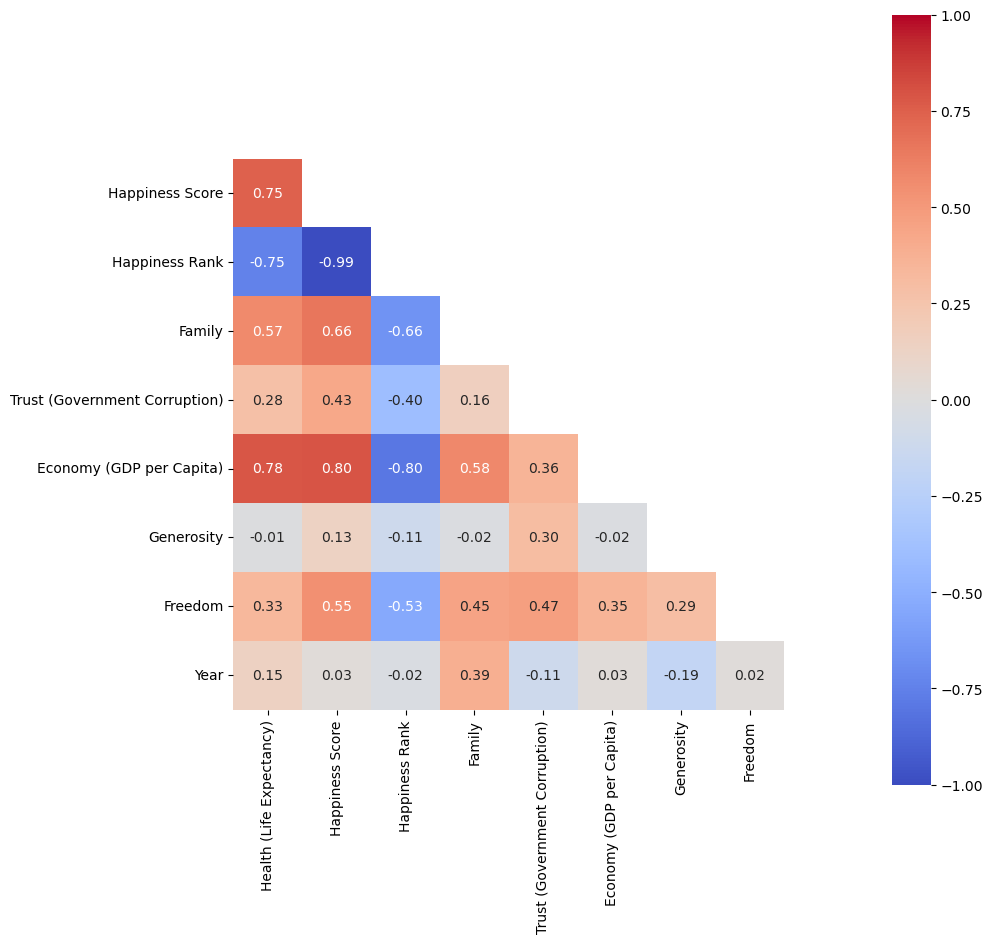

The correlation between Happiness Score and:

Economy (GDP per Capita) is statistically significant.
Family is statistically significant.
Health (Life Expectancy) is statistically significant.
Freedom is statistically significant.
Trust (Government Corruption) is statistically significant.
Generosity is statistically significant.


In [ ]:
# Masked correlation matrix
corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    square=True,
    mask=mask,
)

# For x-axis, remove the last tick and label
xticks_locs = ax.get_xticks()[:-1]
xticks_labels = [label.get_text() for label in ax.get_xticklabels()[:-1]]
ax.set_xticks(xticks_locs)
ax.set_xticklabels(xticks_labels)

# For y-axis, define new tick locations and remove the first label
yticks_locs = np.arange(1.5, len(corr.index), 1)
yticks_labels = [label.get_text() for label in ax.get_yticklabels()[1:]]
ax.set_yticks(yticks_locs)
ax.set_yticklabels(yticks_labels)

plt.show()

print("The correlation between Happiness Score and:\n")
for feature in features:
    corr, p_value = pearsonr(data[feature], data["Happiness Score"])
    if p_value < 0.05:
        print(feature, "is statistically significant.")
    else:
        print(feature, "is not statistically significant.")

Based on the correlation matrix, the features that contribute the most to happiness are Economy (GDP per Capita), Family (Social support), and Health (Life Expectancy). A president of a country should focus on improving the economy, fostering social support, and promoting public health to make citizens happier. Additionally, they may also consider promoting freedom, reducing corruption, and encouraging generosity, as these factors also have a statistically significant, positive correlation with happiness. While the specific tactics they use should be tailored to the country, some broad strategies include improving the economy by investing in infrastructure and education, fostering social support by providing social services and promoting community engagement, promoting public health by investing in healthcare and education, promoting freedom by protecting human rights and civil liberties, reducing corruption by increasing transparency and accountability, and encouraging generosity by promoting volunteerism and philanthropy.


# Feature Selection


## Model Selection


Feature selection can be performed with filter and wrapper methods, or through embedded methods, which perform feature selection as part of the model training process. Embedded methods are generally preferred because they are more efficient and can potentially perform better than filter and wrapper methods. For this task, the embedded methods to be used are Ridge Regression, Decision Tree Regressor, and Random Forest Regressor. These models were chosen because they are simple and easy to interpret, commonly used for regression tasks, are relatively fast to train, and can handle large datasets. The ridge regression model is a good baseline model, while the decision tree and random forest models are more complex and can potentially perform better. All the models were fine-tuned to find the best hyperparameters. This involves cross-validation and it should improve their performance on the test set. It will, however, increase the training time. Especially for the random forest model, which is already slow to train.

Ridge regression is a linear regression technique that introduces a regularization term to the MAE function in order to address the problem of overfitting. It is a type of regularized linear regression that adds a penalty term proportional to the sum of the squared coefficients of the model. Linear regression is a simple algorithm that models the relationship between a dependent variable (happiness ranking in this case) and one or more independent variables (features). The model assumes a linear relationship between the dependent and independent variables and tries to find the best-fitting straight line that minimizes the sum of squared residuals (differences between observed and predicted values).

Decision tree regressors are a type of model that recursively splits the dataset into subsets based on the feature values. Each split is determined by the feature that provides the highest reduction in variance (or another impurity measure). The process continues until a stopping criterion is met, such as reaching a maximum depth or minimum number of samples per leaf. The prediction is made by averaging the target values in the final leaf node.

Random forest regressors are an ensemble method that combines multiple decision trees. Each tree is trained on a random subset of the data with replacement (bootstrapped sample), and at each split, only a random subset of features is considered. This adds randomness to the process, reducing the risk of overfitting. The final prediction is obtained by averaging the predictions from all trees in the forest.


## Model Training


In [ ]:
# Preprocess the data
score = data["Happiness Score"]
data = data.drop(columns=["Happiness Score", "Country"])

# Split the data into features and target variables
X = data.drop(columns=["Happiness Rank"])
y = data["Happiness Rank"]

# Train and evaluate each model
X_train, X_test = X[: -len(data_2019)], X[-len(data_2019) :]
y_train, y_test = y[: -len(data_2019)], y[-len(data_2019) :]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Default Ridge Regression
default_ridge = Ridge(random_state=42)
default_ridge.fit(X_train, y_train)

# Fine-tuned Ridge Regression
best_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100], cv=5)
best_ridge.fit(X_train, y_train)

# Default Decision Tree
default_tree = DecisionTreeRegressor(random_state=42)
default_tree.fit(X_train, y_train)

# Fine-tuned Decision Tree
tree = DecisionTreeRegressor(random_state=42)
params_tree = {
    "max_depth": range(1, 11),
    "min_samples_split": range(2, 21),
    "min_samples_leaf": range(1, 21),
}

grid_search_tree = GridSearchCV(
    tree, params_tree, cv=5, scoring="neg_mean_squared_error"
)
grid_search_tree.fit(X_train, y_train)

best_tree = grid_search_tree.best_estimator_

# Default Random Forest
default_forest = RandomForestRegressor(random_state=42)
default_forest.fit(X_train, y_train)

# Fine-tune Random Forest
forest = RandomForestRegressor(random_state=42)
params_forest = {
    "n_estimators": [10, 50, 100, 200, 500],
    "max_depth": range(1, 11),
    "min_samples_split": range(2, 21),
    "min_samples_leaf": range(1, 21),
}

random_search_forest = RandomizedSearchCV(
    forest,
    params_forest,
    n_iter=100,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
)
random_search_forest.fit(X_train, y_train)

best_forest = random_search_forest.best_estimator_

models = {
    "Ridge Regression": {
        "Default": default_ridge,
        "Fine-tuned": best_ridge,
    },
    "Decision Tree": {
        "Default": default_tree,
        "Fine-tuned": best_tree,
    },
    "Random Forest": {
        "Default": default_forest,
        "Fine-tuned": best_forest,
    },
}

Here, we trained the models using the training data.


## Model Testing


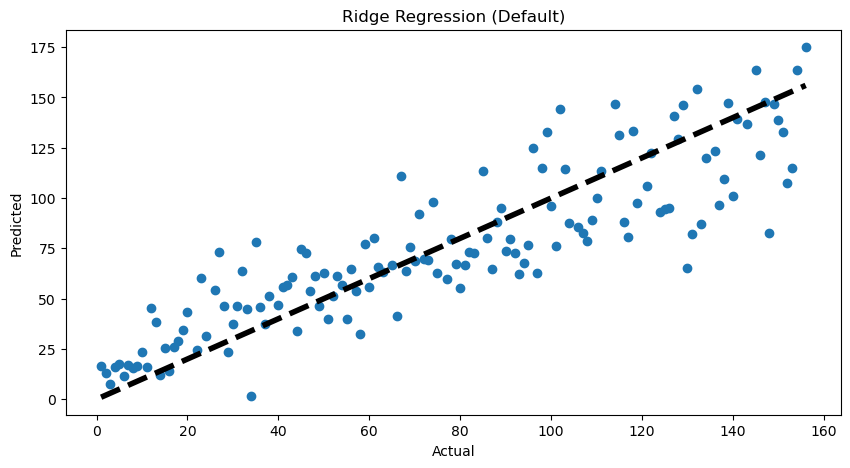

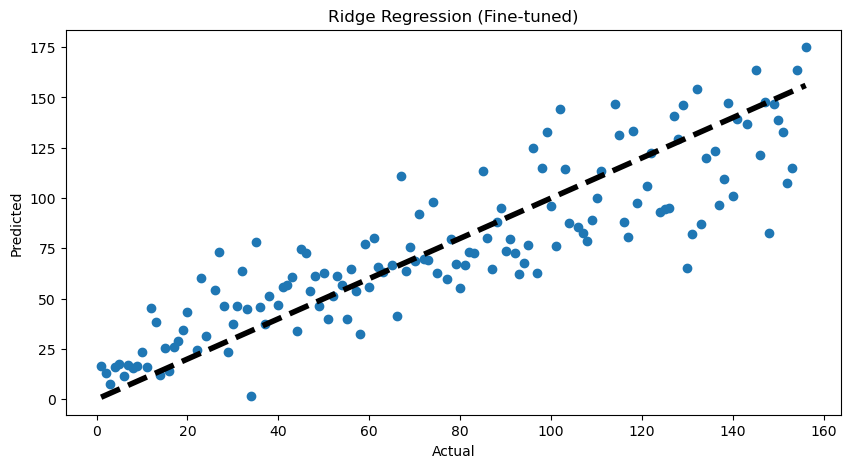

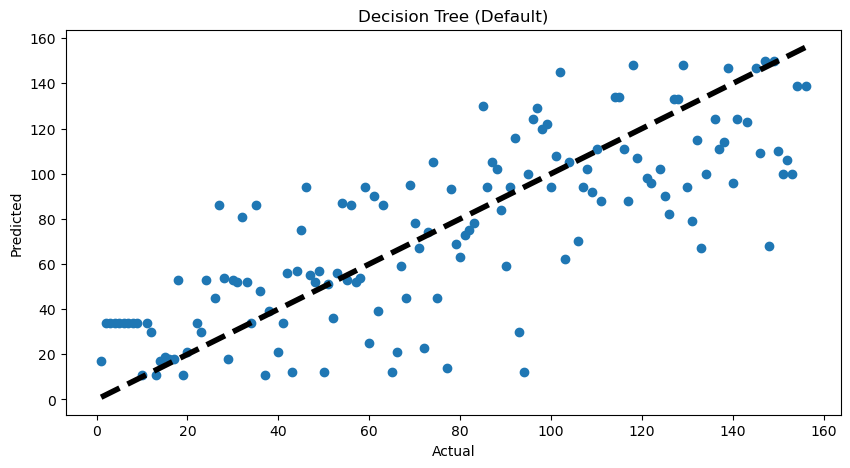

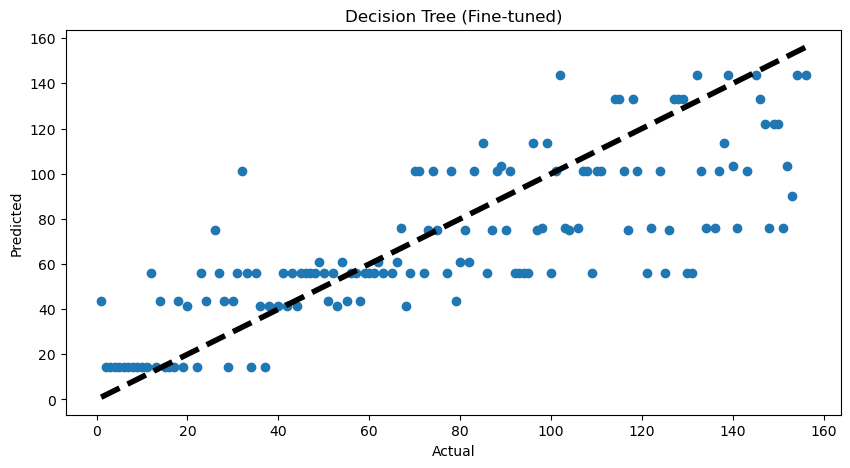

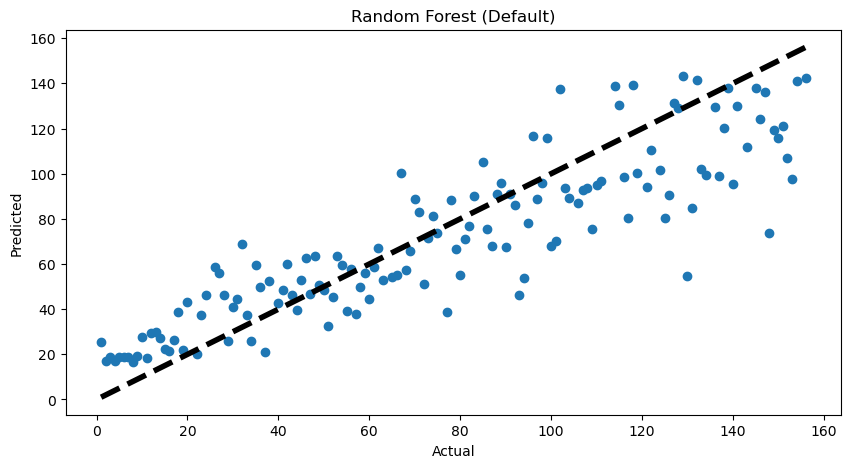

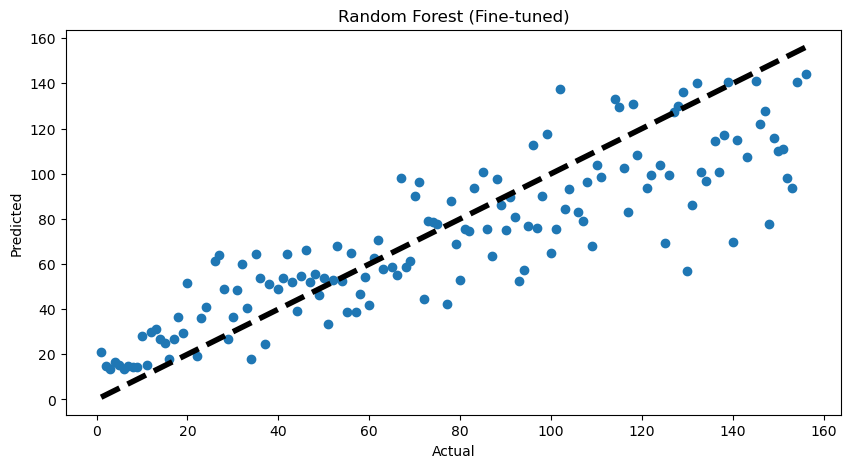

Ridge Regression (Default)
MAE: 17.3024
R²: 0.7636
RSE: 1.8913

Ridge Regression (Fine-tuned)
MAE: 17.3024
R²: 0.7636
RSE: 1.8913

Decision Tree (Default)
MAE: 22.4184
R²: 0.6016
RSE: 2.4553

Decision Tree (Fine-tuned)
MAE: 21.2794
R²: 0.6020
RSE: 2.4539

Random Forest (Default)
MAE: 17.1643
R²: 0.7619
RSE: 1.8981

Random Forest (Fine-tuned)
MAE: 18.1197
R²: 0.7338
RSE: 2.0068



In [ ]:
results = {}

# loop through each model
for model_name, model in models.items():
    for version, modelo in model.items():
        y_pred = modelo.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        df = X_test.shape[0] - X_test.shape[1] - 1  # dof = n - p - 1
        rse = np.sqrt(mean_squared_error(y_test, y_pred) / df)

        # plot the results
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test, y_pred)
        plt.plot(
            [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4
        )
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(model_name + " (" + version + ")")
        plt.show()

        # save the results, including the model
        results[model_name + " (" + version + ")"] = {
            "MAE": mae,
            "R²": r2,
            "RSE": rse,
            "Model": modelo,
        }

for model_name, model in models.items():
    for version, modelo in model.items():
        print(model_name + " (" + version + ")")
        for metric, value in results[model_name + " (" + version + ")"].items():
            if metric != "Model":
                print(f"{metric}: {value:.4f}")
        print()

The models are evaluated using the root mean squared error (RSE), mean absolute error (MAE), and R<sup>2</sup> scores. The RSE is the square root of the mean squared error (MSE), which is the average of the squared differences between the predicted and actual values. The MAE is the average of the absolute differences between the predicted and actual values. The R<sup>2</sup> score is the proportion of the variance in the dependent variable that can be explained by the model. The RSE and MAE are both measures of the model's accuracy, while the R<sup>2</sup> score is a measure of the model's goodness of fit.

#### Ridge Regression

The Ridge Regression models have a moderate RSE and MAE, indicating that the predicted happiness rankings have some deviation from the actual rankings. The R<sup>2</sup> scores indicate that 75% of the variance in the happiness rankings can be explained by the models. Overall, the ridge regression models show a decent performance, with the fine-tuned model performing similarly to the default model.

#### Decision Tree Regressor

The Decision Tree Regressor models have a higher RSE and MAE compared to the ridge regression model, indicating that their predictions deviate more from the actual rankings. The R<sup>2</sup> scores indicate that 60% of the variance in the happiness rankings can be explained by the models. While the fine-tuned model performs better than the default model, neither is as good as the ridge regression models.

#### Random Forest Regressor

The Random Forest Regressor models have the lowest MAE, but their RSE is very similar to that of the ridge regression models. Their R<sup>2</sup> scores indicate that about 75% of the variance in the happiness rankings can be explained by the models. Overall, the random forest models perform better than the decision tree models, and about as good as the ridge regression models. The fine-tuned model performs slightly worse than the default model, but the difference is negligible.


# Feature Engineering


## Feature Creation


In [ ]:
def custom_happiness_score(model):
    # get the weights and bias from the model
    weights = model.coef_ if hasattr(model, "coef_") else model.feature_importances_
    bias = model.intercept_ if hasattr(model, "intercept_") else 0
    weights = weights / weights.sum()

    # print the custom happiness formula
    print("Custom Score = ", end="")
    for feature, weight in sorted(
        zip(X.columns, weights), key=lambda x: x[1], reverse=True
    ):
        print("{:.2f}".format(weight), "*", feature, "+ ", end="")
    print("{:.2f}".format(bias) if bias != 0 else "\b\b")

    # calculate the custom happiness score
    return X.dot(weights) + bias


# Get the model with the lowest RSE
model = results[min(results.items(), key=lambda x: x[1]["RSE"])[0]]["Model"]

# Apply the custom happiness score function
custom_score = custom_happiness_score(model)

Custom Score = 0.34 * Economy (GDP per Capita) + 0.23 * Family + 0.22 * Health (Life Expectancy) + 0.15 * Freedom + 0.06 * Trust (Government Corruption) + 0.05 * Generosity + -0.04 * Year + 204.40


Here, we created a new feature "Custom Score" by using the weights and bias determined by the best performing model.


## Correlation Analysis


### Qualitative Analysis


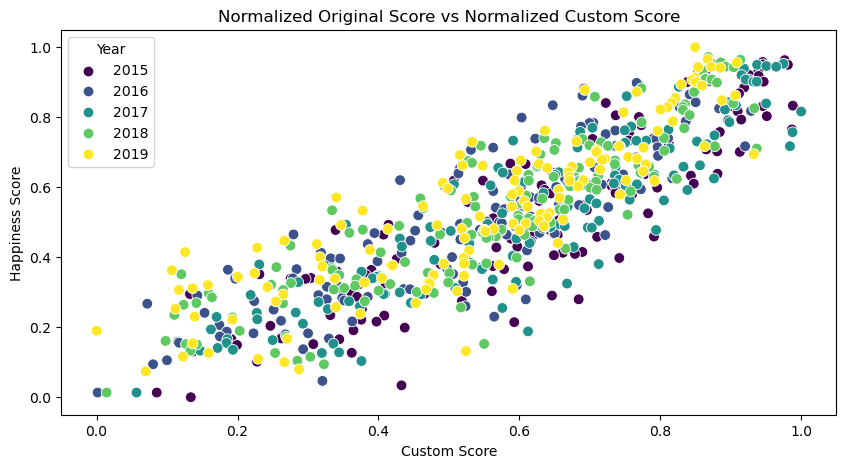

Correlation Coefficient: 0.8658565568394857


In [ ]:
# Function to normalize scores
def normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))


# Normalize the happiness scores and custom scores
data["Happiness Score"] = normalize(score)
data["Custom Score"] = normalize(custom_score)

# Visualize the relationship between happiness score and custom score
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=data,
    x="Custom Score",
    y="Happiness Score",
    hue="Year",
    palette="viridis",
    s=60,
)
plt.title("Normalized Original Score vs Normalized Custom Score")
plt.show()

# Correlation coefficient
corr_coef = np.corrcoef(custom_score, score)[0, 1]
print("Correlation Coefficient:", corr_coef)

The scatterplot shows that the Custom Happiness Score has a strong positive correlation with the actual Happiness Score. The correlation coefficient is ~0.86, which is higher than the correlation coefficients between the actual Happiness Score and the individual features. This indicates that the custom score is a better predictor of happiness than the individual features.


### Quantitative Analysis


In [ ]:
# Check normality for both scores
normality_results = {}
for score_type in ["Happiness Score", "Custom Score"]:
    _, p_value = shapiro(data[score_type])
    normality_results[score_type] = p_value

data["Country"] = all_countries
data["Subject"] = data["Country"] + "-" + data["Year"].astype(str)

# Check sphericity
spher, _, _, _, _ = pg.sphericity(
    data.pivot_table(index="Subject", columns="Year", values="Happiness Score"),
    method="chi2",
)

# If normality, sphericity assumptions are met
if all(p_value > 0.01 for p_value in normality_results.values()) and spher:
    # two-way repeated measures ANOVA
    model = ols(
        "Value ~ C(Type) * C(Year)",
        data=data.melt(id_vars="Year", var_name="Type", value_name="Value"),
    ).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print("Two-way repeated measures ANOVA results:")
    print(anova_table)
else:
    # Friedman test
    years = data["Year"].unique()
    complete_data = data.groupby("Country").filter(
        lambda x: x["Year"].nunique() == len(years)
    )
    scores_by_year = [
        complete_data[complete_data["Year"] == year][
            ["Happiness Score", "Custom Score"]
        ]
        for year in years
    ]
    fried_stat, fried_p_value = friedmanchisquare(*(scores_by_year))

    print("Friedman test results:")
    print(f"Chi-square = {fried_stat:.4f}, p = {fried_p_value:.4f}")

Friedman test results:
Chi-square = 1316936.7298, p = 0.0000


The Friedman test is a non-parametric test used to compare the means of three or more paired groups. Since it was run, the data did not meet the normality and/or sphericity requirements for the ANOVA. The results show a very high chi-square value and a very low p-value. This means that there is strong evidence against the null hypothesis; we reject the null hypothesis and conclude that there are significant differences in the Happiness Score and Custom Score across the years.
